In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

# ======
from cryptic_rnn import *

# RNN setup

In [2]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict, xavier_gain):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict, xavier_gain):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict, xavier_gain) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    
    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list = [r['acc'][:,1] for r in res]
    loss_list = [r['loss'] for r in res]
    losses = np.hstack(loss_list)
    acc_train = np.array(acc_train_list).T
    acc_test = np.array(acc_test_list).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

#     plotNNs([losses], [acc_train, acc_test], \
#             ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    ft_tests_acc = np.array([acc_test_list[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, hidden_size, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)


    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return {'res':res, 'r2': r2, 'all_final_accs': final_accs, 'mean_acc_final': fully_trained_test_acc,\
            'all_dfs':alldfs, 'df_trials': dfs, 'acc_std': fully_trained_test_acc_std}


In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 104

xavier_gain = 0.1

# Experiments

Final accuracy against ratio of other/self



In [4]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms, cue_dict)
p_neg = generate_neg_primitives(all_syms, cue_dict)
print(p_neg)

{'A': 16, 'B': 11, 'C': 15, 'D': 6}
[[('-', 'A'), '=', -16], [('-', 'B'), '=', -11], [('-', 'C'), '=', -15], [('-', 'D'), '=', -6]]


trainseqs  [['A', ('+', 'B'), '=', 27], ['B', ('+', 'C'), '=', 26], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 22], ['A', '=', 16], ['B', '=', 11], ['C', '=', 15], ['D', '=', 6]]
testseqs  [['A', ('+', 'A'), '=', 32], ['A', ('+', 'C'), '=', 31], ['A', ('+', 'D'), '=', 22], ['B', ('+', 'A'), '=', 27], ['B', ('+', 'B'), '=', 22], ['B', ('+', 'D'), '=', 17], ['C', ('+', 'A'), '=', 31], ['C', ('+', 'B'), '=', 26], ['C', ('+', 'C'), '=', 30], ['D', ('+', 'B'), '=', 17], ['D', ('+', 'C'), '=', 21], ['D', ('+', 'D'), '=', 12]]
run time:  1.298193351427714
25
total time:  1.3022799531618754
25 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.88 
-----------



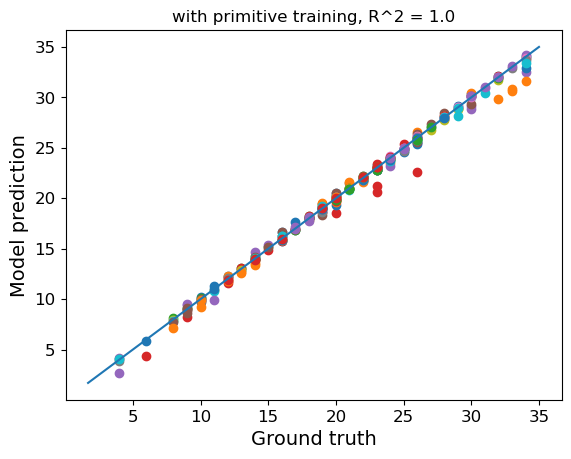

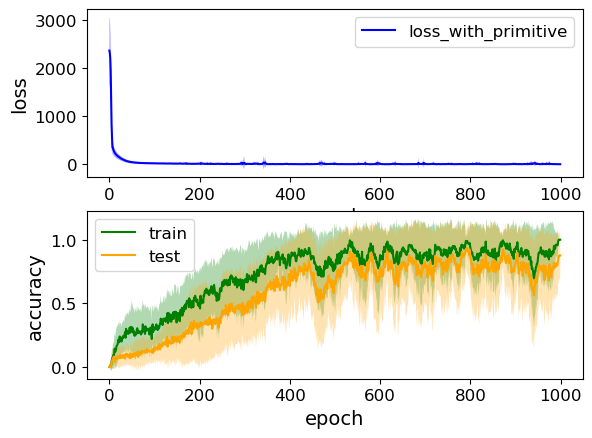

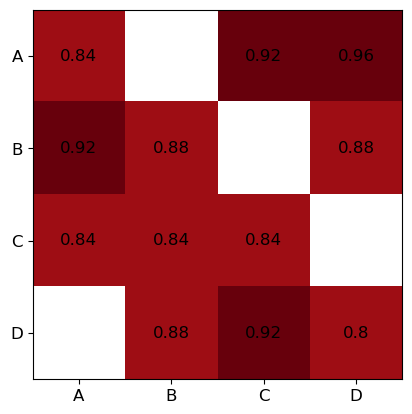

In [8]:
num_sims = 32
xavier_gain = 0.0000001
hidden_size = 20
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  2.2161623160044353
30
total time:  2.219842747847239
30 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------



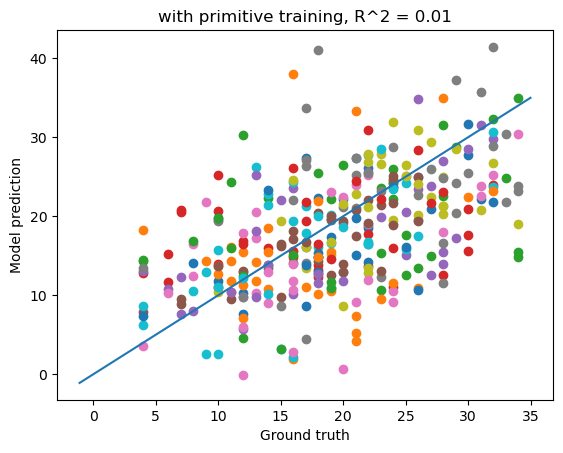

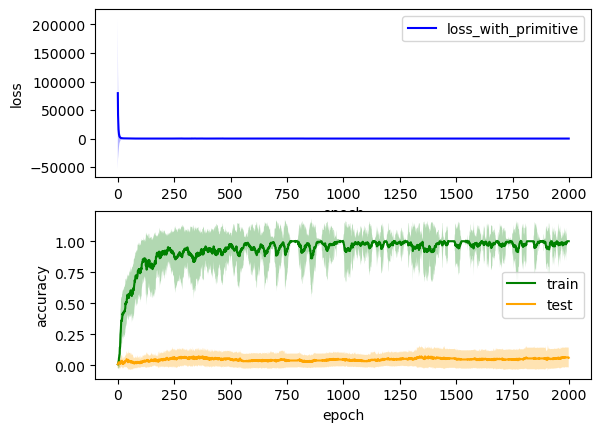

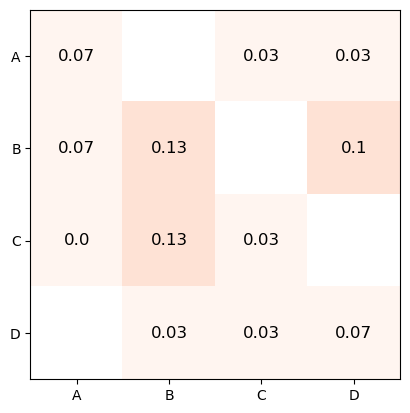

In [34]:
num_sims = 32
epochs = 2000
xavier_gain = 5
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.1655515670776366
31
total time:  1.1691716313362122
31 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.23 
-----------



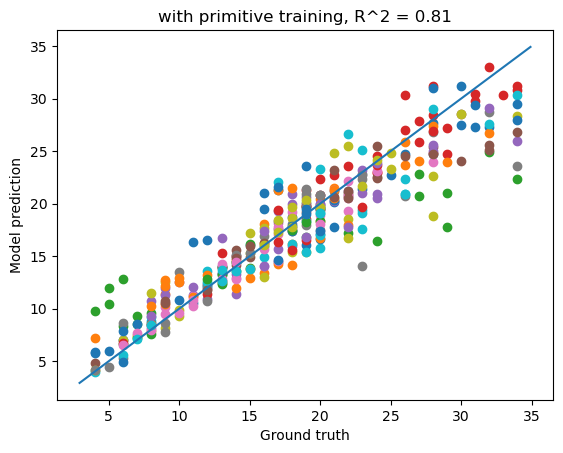

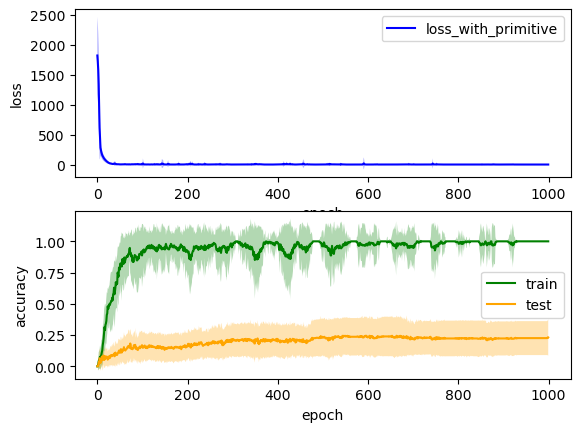

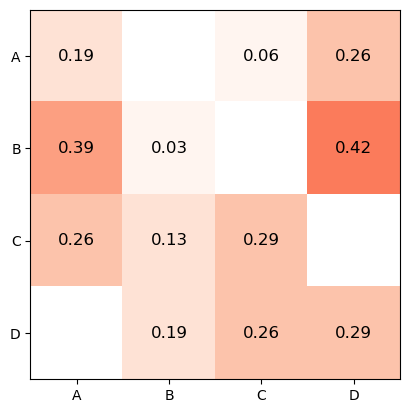

In [30]:
num_sims = 32
xavier_gain = 1
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.0699105660120647
25
total time:  1.0729719638824462
25 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.43 
-----------



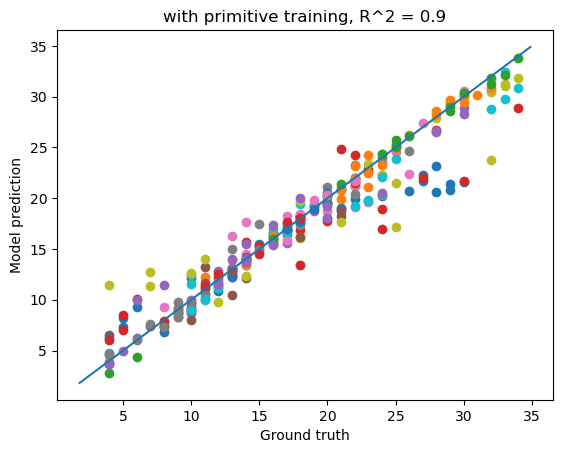

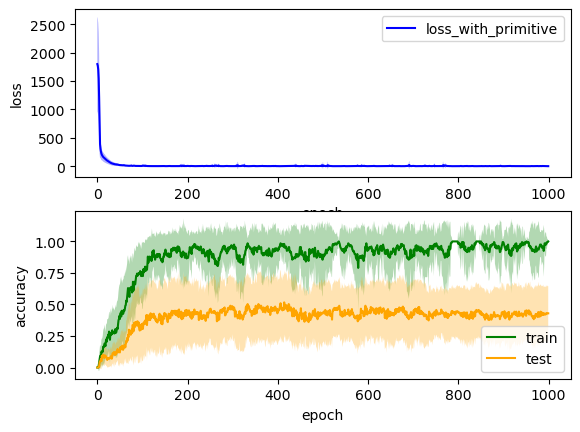

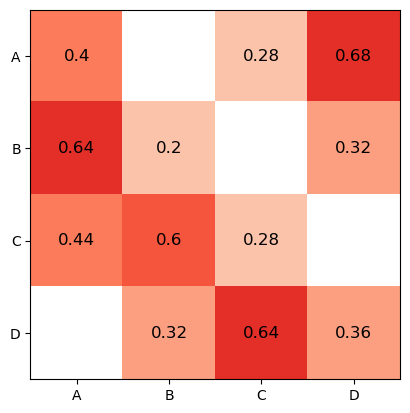

In [26]:
num_sims = 32
xavier_gain = 0.1
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.0742913484573364
27
total time:  1.0775368173917135
27 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.74 
-----------



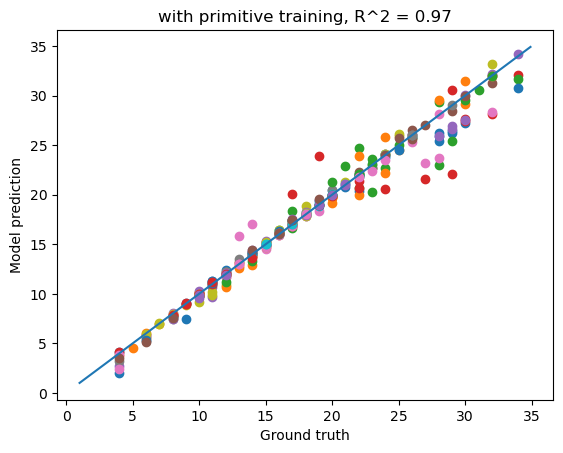

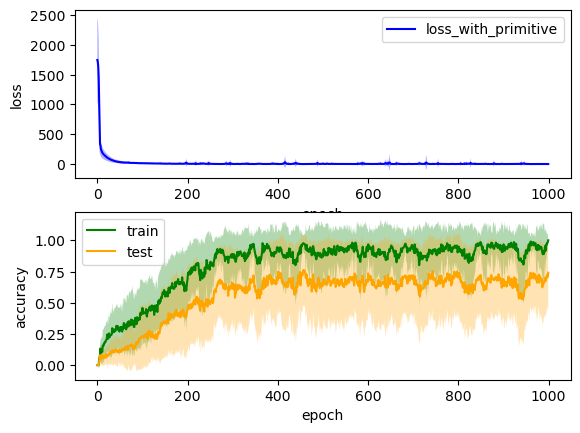

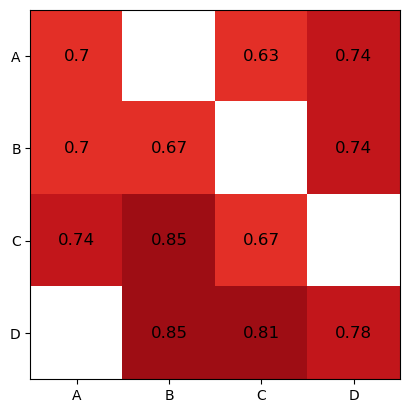

In [28]:
num_sims = 32
xavier_gain = 0.01
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.0636184692382813
22
total time:  1.0678783694903056
22 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.95 
-----------



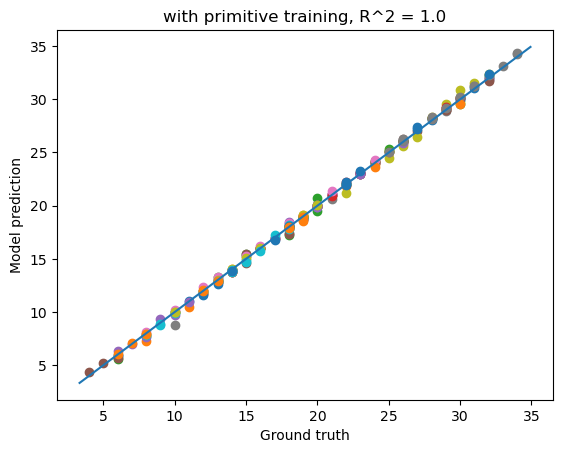

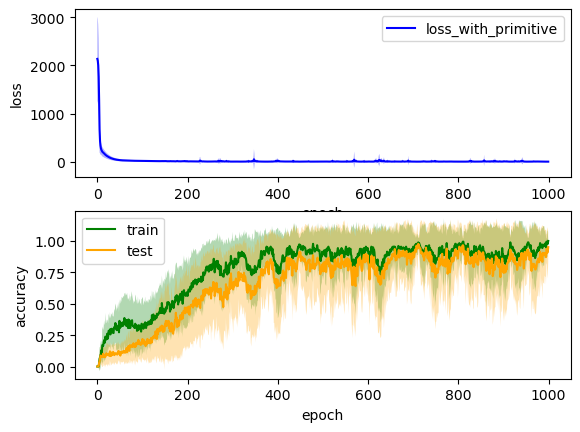

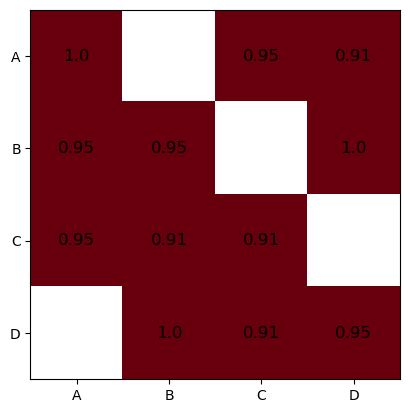

In [29]:
num_sims = 32
xavier_gain = 0.001
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.9227759838104248
24
total time:  1.9257066329320272
24 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.85 
-----------



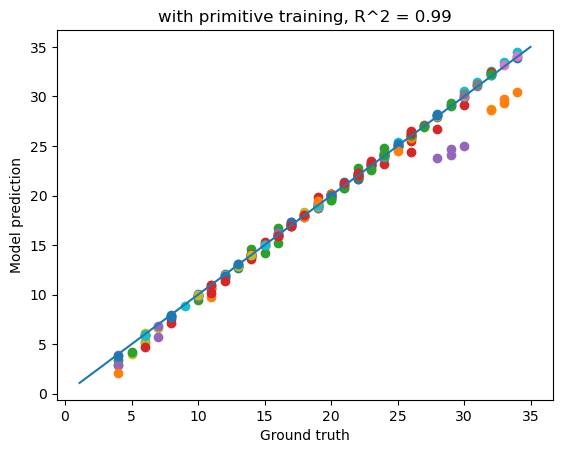

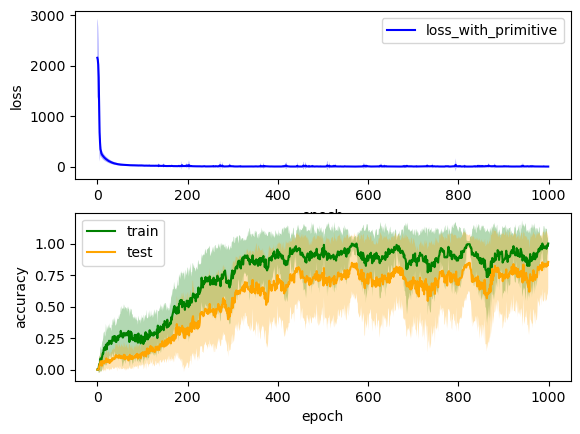

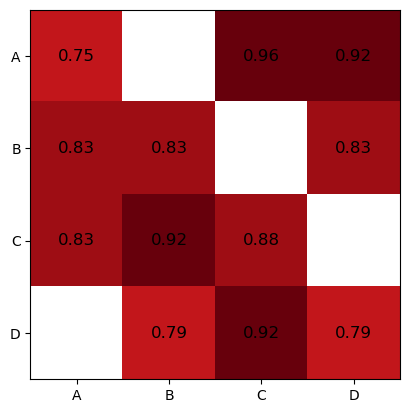

In [32]:
num_sims = 32
xavier_gain = 0.0001
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

trainseqs  [['A', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 30], ['C', ('+', 'D'), '=', 31], ['D', ('+', 'A'), '=', 23], ['A', '=', 6], ['B', '=', 16], ['C', '=', 14], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 22], ['B', ('+', 'B'), '=', 32], ['B', ('+', 'D'), '=', 33], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 30], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 33], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  1.086705748240153
27
total time:  1.089827263355255
27 / 32  rnns trained to 100% accuracy.        
 Mean test acc =  0.93 
-----------



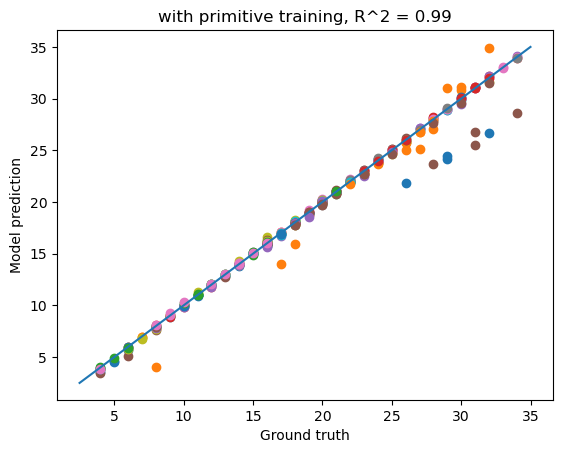

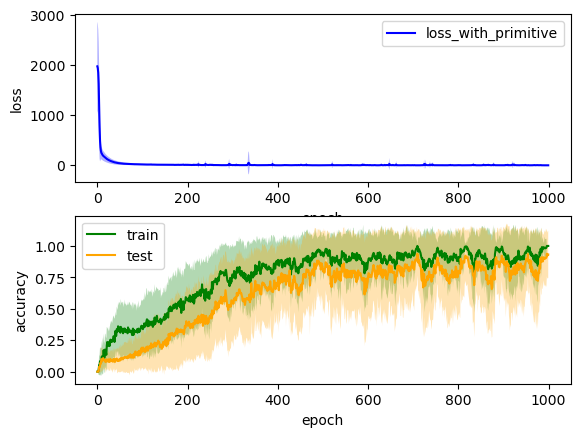

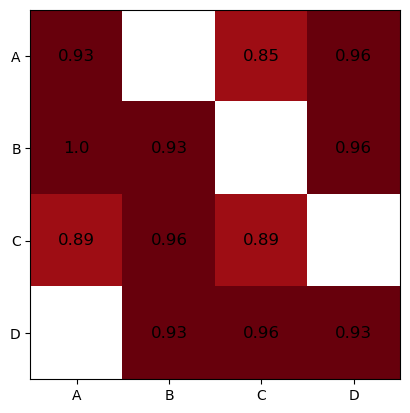

In [31]:
num_sims = 32
xavier_gain = 0.00001
# addition
trainseqs = generate_other(ops, all_syms, cue_dict) + p
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict, xavier_gain)
df1 = res1['df_trials']

fig, ax = plt.subplots(1,1)
heatmap_acc(num_inputs, res1['df_trials'], ax)

In [13]:
num_sims = 80
ops = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)
print(p_neg)

{'A': 8, 'B': 4, 'C': 5, 'D': 7}
[[('-', 'A'), '=', -8], [('-', 'B'), '=', -4], [('-', 'C'), '=', -5], [('-', 'D'), '=', -7]]


trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 4], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0], ['A', '=', 8], ['B', '=', 4], ['C', '=', 5], ['D', '=', 7]]
testseqs  [['A', ('-', 'D'), '=', 1], ['B', ('-', 'D'), '=', -3], ['C', ('-', 'D'), '=', -2], ['D', ('-', 'A'), '=', -1], ['D', ('-', 'B'), '=', 3], ['D', ('-', 'C'), '=', 2], ['D', ('-', 'D'), '=', 0]]
run time:  4.325193619728088
62
total time:  4.332090135415395
62 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.07 
-----------



label      pred       acc
trial                                             
['D', '-', 'D', '=']  0.000000  0.147919  0.241935
['D', '-', 'A', '='] -1.870968  1.320869  0.064516
['D', '-', 'B', '=']  0.000000  2.918710  0.064516
['D', '-', 'C', '='] -0.709677  1.644418  0.064516
['A', '-', 'D', '=']  1.870968  0.324331  0.016129
['B', '-', 'D', '=']  0.000000 -1.664701  0.016129
['C', '-', 'D', '=']  0.709677 -0.864136  0.016129

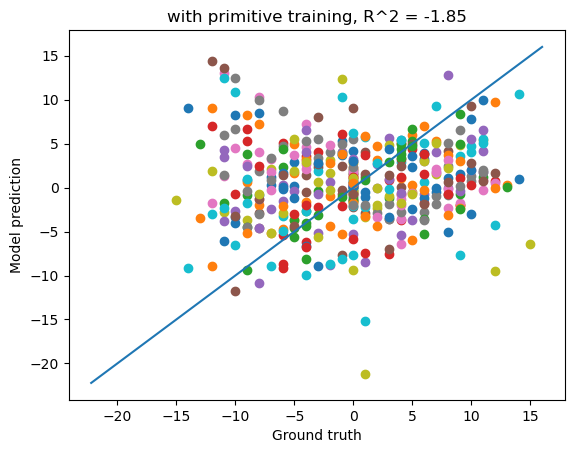

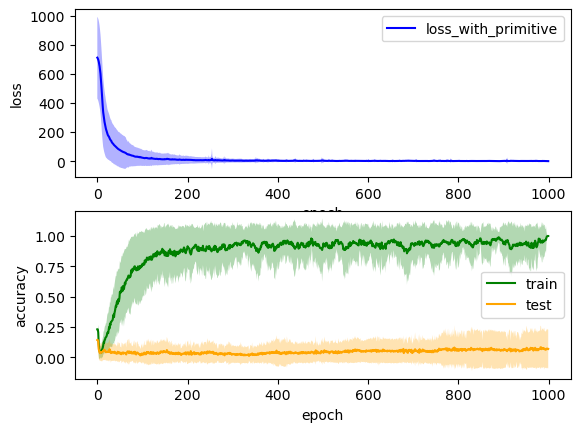

In [14]:
# Subtraction with primitives
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 4], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0], ['A', '=', 8], ['B', '=', 4], ['C', '=', 5], ['D', '=', 7], [('-', 'A'), '=', -8], [('-', 'B'), '=', -4], [('-', 'C'), '=', -5], [('-', 'D'), '=', -7]]
testseqs  [['A', ('-', 'D'), '=', 1], ['B', ('-', 'D'), '=', -3], ['C', ('-', 'D'), '=', -2], ['D', ('-', 'A'), '=', -1], ['D', ('-', 'B'), '=', 3], ['D', ('-', 'C'), '=', 2], ['D', ('-', 'D'), '=', 0]]
run time:  8.818913129965464
52
total time:  8.823614831765493
52 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.32 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -1.230769 -1.146903  0.423077
['B', '-', 'D', '='] -0.307692 -0.303171  0.423077
['C', '-', 'D', '='] -1.903846 -1.680032  0.423077
['D', '-', 'C', '=']  1.903846  0.868522  0.307692
['D', '-', 'B', '=']  0.307692 -0.466795  0.230769
['D', '-', 'A', '=']  1.230769  0.476876  0.211538
['D', '-', 'D', '=']  0.000000 -0.171970  0.211538

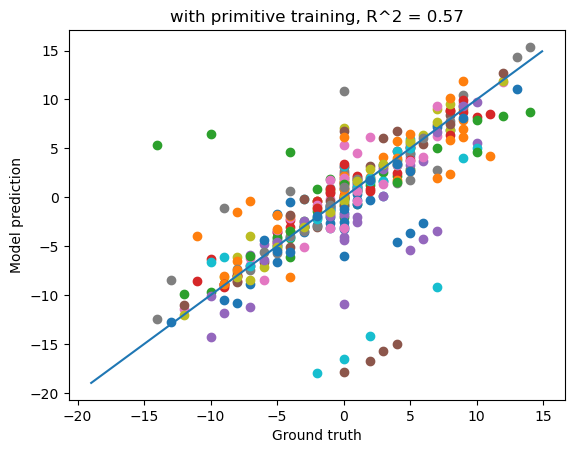

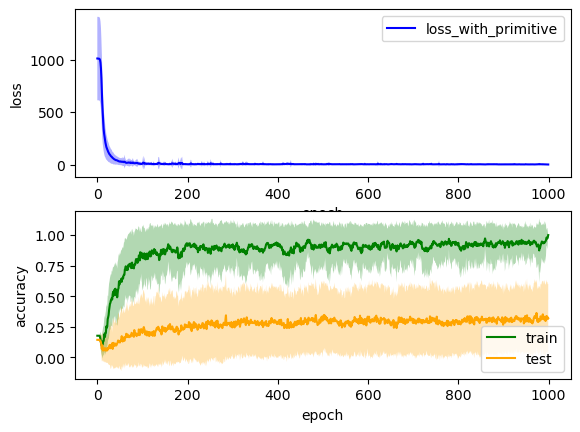

In [15]:
# subtraction with both primitives
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

trainseqs  [['A', ('-', 'B'), '=', 4], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['A', '=', 8], ['B', '=', 4], ['C', '=', 5], ['D', '=', 7], [('-', 'A'), '=', -8], [('-', 'B'), '=', -4], [('-', 'C'), '=', -5], [('-', 'D'), '=', -7]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 3], ['A', ('-', 'D'), '=', 1], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', -2], ['D', ('-', 'A'), '=', -1], ['D', ('-', 'B'), '=', 3], ['D', ('-', 'C'), '=', 2], ['D', ('-', 'D'), '=', 0]]
run time:  4.93391581773758
62
total time:  4.941911613941192
62 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  2.775555  0.225806
['B', '-', 'A', '=']  0.758065  0.995130  0.193548
['B', '-', 'B', '=']  0.000000  1.866036  0.177419
['B', '-', 'D', '='] -0.854839 -0.007626  0.177419
['C', '-', 'D', '='] -0.483871  1.481972  0.177419
['A', '-', 'C', '='] -1.129032 -0.552875  0.161290
['A', '-', 'D', '='] -1.612903 -1.017585  0.161290
['C', '-', 'B', '=']  0.370968  2.087459  0.129032
['A', '-', 'A', '=']  0.000000  1.025862  0.096774
['D', '-', 'A', '=']  1.612903  1.705506  0.096774
['D', '-', 'B', '=']  0.854839  1.937676  0.096774
['D', '-', 'C', '=']  0.483871  1.678483  0.080645
['D', '-', 'D', '=']  0.000000  2.639216  0.048387

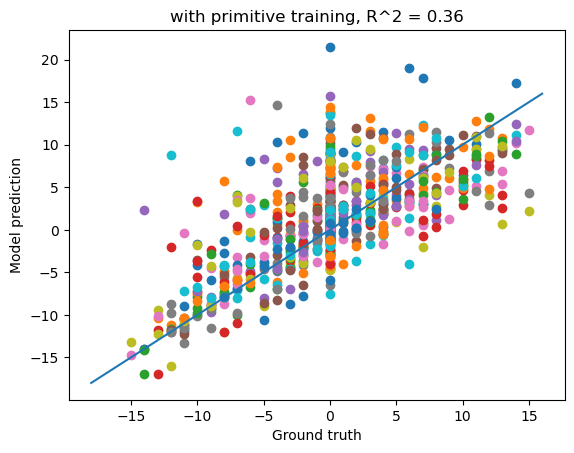

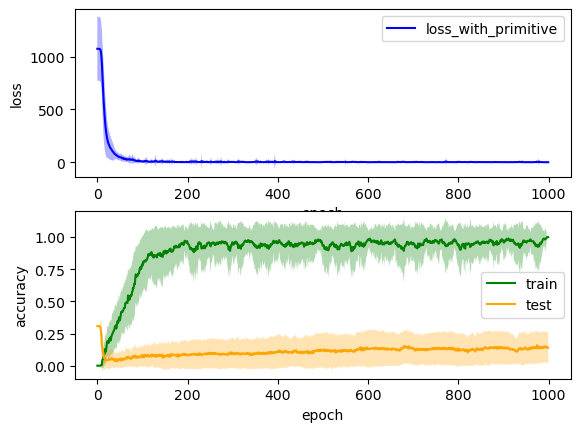

In [16]:
# subtraction with both primitives
trainseqs = generate_other(ops, all_syms[:-1])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 4], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0], [('-', 'A'), '=', -8], [('-', 'B'), '=', -4], [('-', 'C'), '=', -5], [('-', 'D'), '=', -7]]
testseqs  [['A', ('-', 'D'), '=', 1], ['B', ('-', 'D'), '=', -3], ['C', ('-', 'D'), '=', -2], ['D', ('-', 'A'), '=', -1], ['D', ('-', 'B'), '=', 3], ['D', ('-', 'C'), '=', 2], ['D', ('-', 'D'), '=', 0]]
run time:  4.2630226174990336
63
total time:  4.268106480439504
63 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.21 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.460317 -0.843513  0.285714
['C', '-', 'D', '=']  0.619048  0.307301  0.285714
['B', '-', 'D', '=']  1.206349  0.863597  0.190476
['D', '-', 'B', '='] -1.206349 -3.542144  0.190476
['D', '-', 'A', '=']  0.460317 -1.793287  0.174603
['D', '-', 'C', '='] -0.619048 -2.963733  0.158730
['D', '-', 'D', '=']  0.000000 -1.496222  0.158730

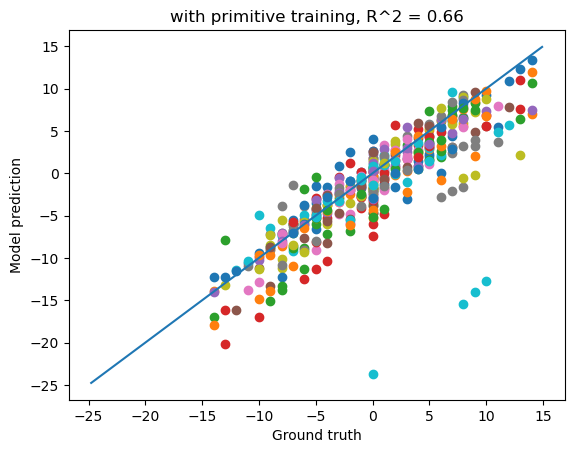

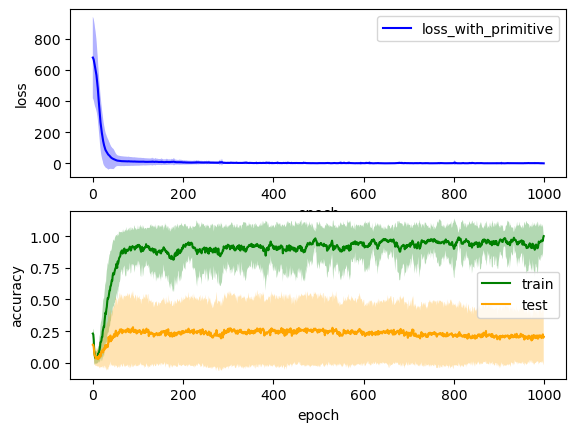

In [17]:
# subtraction with negative primitives
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

# Sequences

In [52]:
ops = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)
print(p_neg)

# only primitives
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
# primitives and negative primitives
trainseqs_n = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p + p_neg
testseqs_n = generate_trials(ops, all_syms, all_syms)
testseqs_n = [s for s in testseqs_n if s not in trainseqs_n]

{'A': 6, 'B': 10, 'C': 5, 'D': 13}
[[('-', 'A'), '=', -6], [('-', 'B'), '=', -10], [('-', 'C'), '=', -5], [('-', 'D'), '=', -13]]


In [53]:
## parameters
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 104

# learning rates and architecture

run time:  7.217262530326844
88
total time:  7.224264164765676
88 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.25 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.147727 -0.630296  0.318182
['B', '-', 'D', '=']  0.181818 -0.246152  0.306818
['C', '-', 'D', '=']  0.306818 -0.154091  0.284091
['D', '-', 'C', '='] -0.306818 -0.734368  0.227273
['D', '-', 'B', '='] -0.181818 -0.492719  0.204545
['D', '-', 'A', '=']  0.147727 -0.226383  0.193182
['D', '-', 'D', '=']  0.000000 -0.380373  0.193182

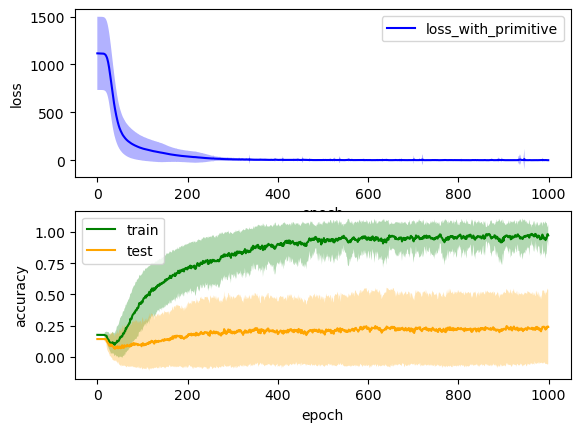

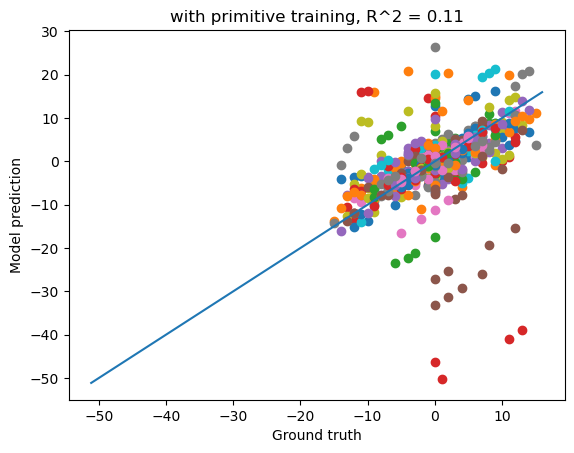

In [54]:
learningRate = 0.001
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
df1 = res1['df_trials']
df1

In [18]:
learningRate = 0.005
num_layers = 3
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
df1 = res1['df_trials']
df1

NameError: name 'trainseqs_n' is not defined

run time:  26.926953597863516
83
total time:  26.936272831757865
83 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.28 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.975904 -0.465606  0.445783
['C', '-', 'D', '='] -0.722892 -0.262937  0.373494
['B', '-', 'D', '=']  0.000000  0.320268  0.361446
['D', '-', 'C', '=']  0.722892 -0.157790  0.228916
['D', '-', 'A', '=']  0.975904  0.094996  0.216867
['D', '-', 'D', '=']  0.000000  0.449450  0.192771
['D', '-', 'B', '=']  0.000000 -0.678062  0.168675

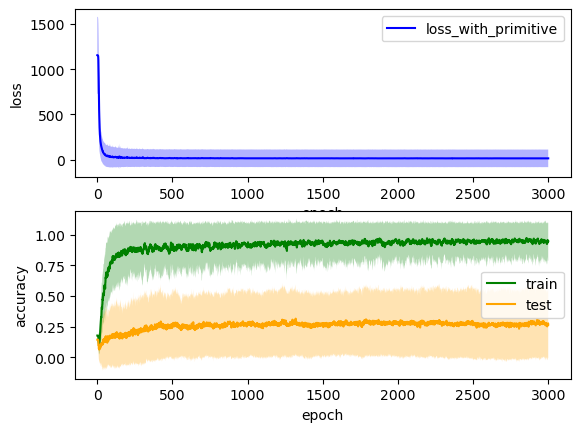

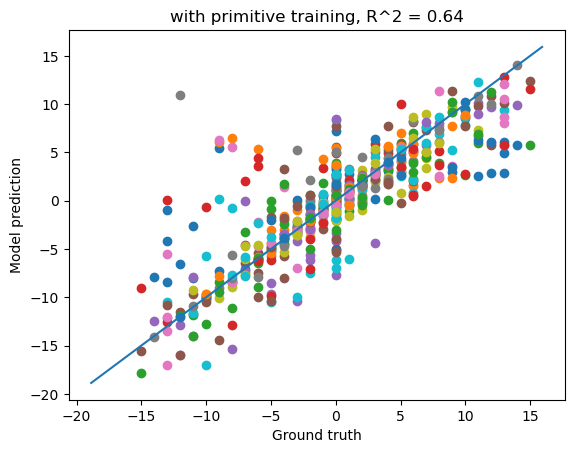

In [56]:
learningRate = 0.005
num_layers = 1
epochs = 3000
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
df1 = res1['df_trials'] 
df1

run time:  9.46516185204188
67
total time:  9.471594202518464
67 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.27 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.343284 -1.274193  0.343284
['C', '-', 'D', '=']  0.970149  0.212648  0.328358
['B', '-', 'D', '=']  0.447761 -0.408725  0.313433
['D', '-', 'B', '='] -0.447761 -0.637847  0.253731
['D', '-', 'A', '=']  0.343284  0.032711  0.238806
['D', '-', 'C', '='] -0.970149 -1.197279  0.208955
['D', '-', 'D', '=']  0.000000 -0.132594  0.194030

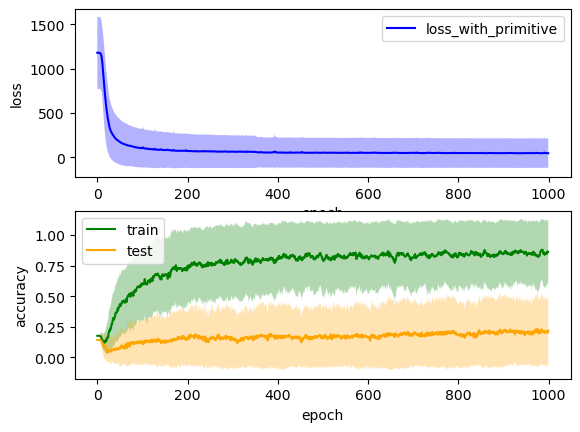

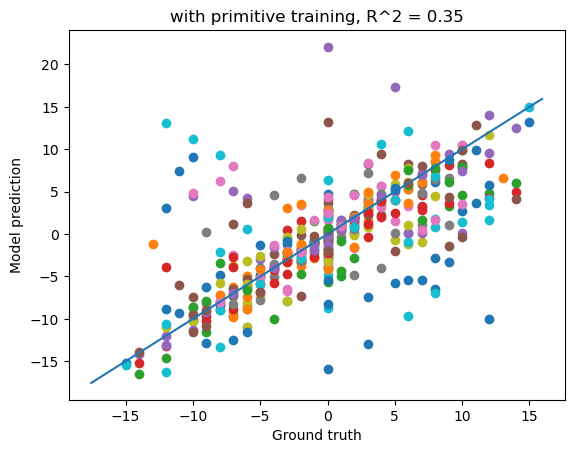

In [57]:
learningRate = 0.005
num_layers = 1
epochs = 1000
hidden_size=10
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
df1 = res1['df_trials'] 
df1

run time:  9.414102800687154
80
total time:  9.420518803596497
80 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.26 
-----------



label      pred     acc
trial                                         
['A', '-', 'D', '='] -0.4000 -0.950599  0.3375
['C', '-', 'D', '=']  0.3375 -0.139372  0.3000
['B', '-', 'D', '=']  0.5000  0.078311  0.2500
['D', '-', 'A', '=']  0.4000  0.659924  0.2500
['D', '-', 'B', '='] -0.5000 -0.188205  0.2500
['D', '-', 'C', '='] -0.3375  0.105578  0.2500
['D', '-', 'D', '=']  0.0000  0.691947  0.2000

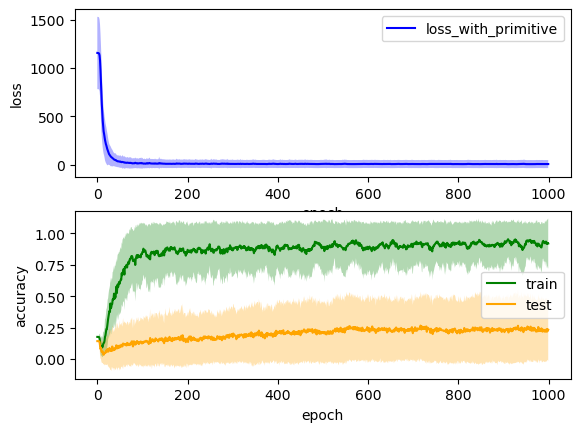

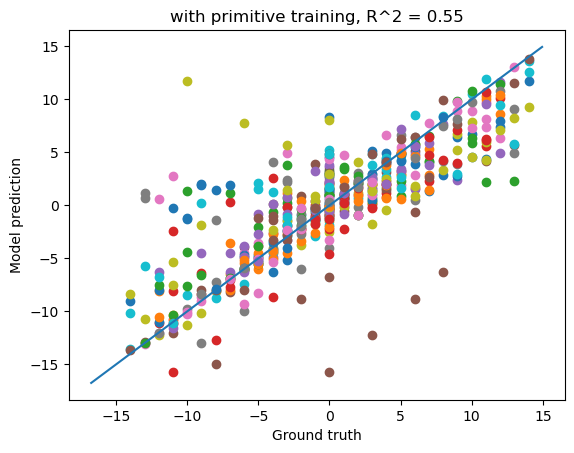

In [58]:
hidden_size=30
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials'] 


run time:  2.8437575538953146
63
total time:  2.849467670917511
63 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.21 
-----------



label      pred       acc
trial                                             
['B', '-', 'D', '=']  0.507937 -1.069834  0.349206
['A', '-', 'D', '=']  0.301587 -1.329845  0.238095
['C', '-', 'D', '=']  1.634921  0.046512  0.222222
['D', '-', 'B', '='] -0.507937 -0.182080  0.206349
['D', '-', 'C', '='] -1.634921 -0.970527  0.190476
['D', '-', 'A', '='] -0.301587 -0.143425  0.158730
['D', '-', 'D', '=']  0.000000 -0.448148  0.126984

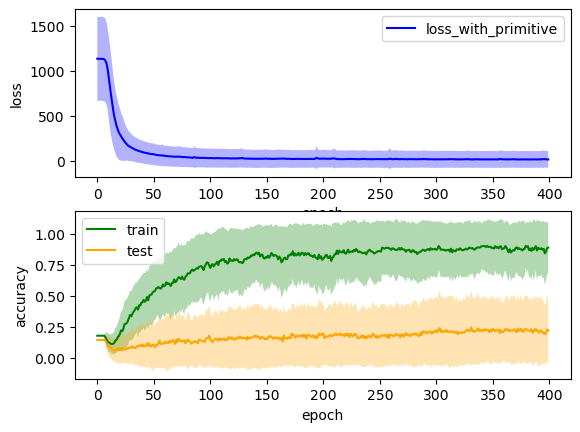

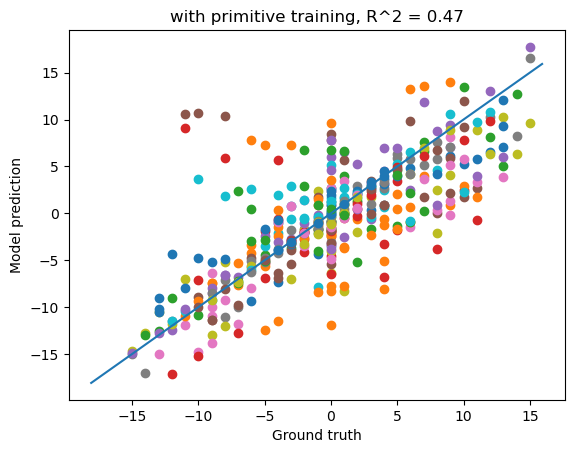

In [60]:
epochs = 400
hidden_size=15
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials'] 


run time:  2.6723850846290587
65
total time:  2.678225751717885
65 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '=']  0.169231  0.058165  0.353846
['B', '-', 'D', '='] -0.061538 -0.255237  0.323077
['D', '-', 'C', '='] -0.384615 -0.255536  0.261538
['C', '-', 'D', '=']  0.384615  0.069873  0.246154
['D', '-', 'B', '=']  0.061538  0.327038  0.200000
['D', '-', 'A', '='] -0.169231 -0.026124  0.184615
['D', '-', 'D', '=']  0.000000  0.285300  0.138462

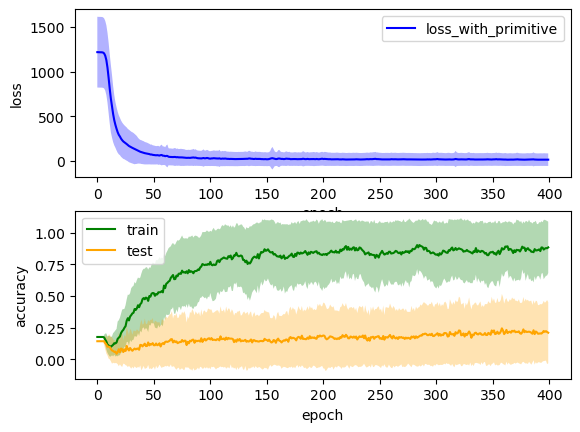

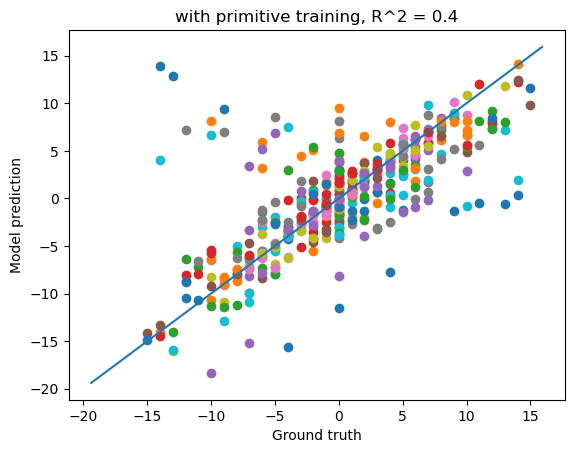

In [61]:
epochs = 400
hidden_size=20
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials'] 


run time:  17.889592945575714
74
total time:  17.899197280406952
74 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.26 
-----------



label      pred       acc
trial                                             
['B', '-', 'D', '='] -0.635135 -1.262568  0.405405
['C', '-', 'D', '=']  0.243243 -0.279588  0.364865
['A', '-', 'D', '=']  0.378378 -0.033786  0.297297
['D', '-', 'C', '='] -0.243243 -0.306648  0.229730
['D', '-', 'A', '='] -0.378378 -0.384670  0.202703
['D', '-', 'B', '=']  0.635135  0.723100  0.189189
['D', '-', 'D', '=']  0.000000 -0.008343  0.135135

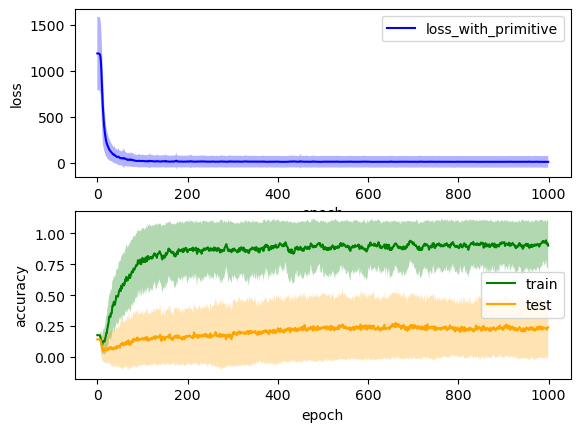

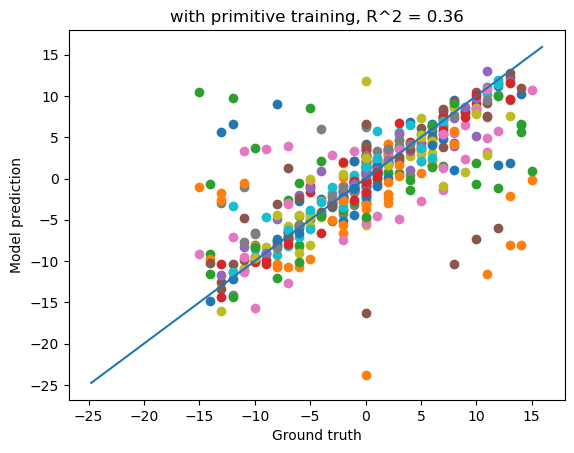

In [62]:
epochs = 1000
hidden_size=20
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials'] 


# RNN architectures

In [85]:
# standard Xavier normal, gain = 1
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True) 
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

KeyboardInterrupt: 

run time:  7.329555682341257
78
total time:  7.336136515935262
78 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.17 
-----------



label      pred       acc
trial                                             
['C', '-', 'D', '=']  0.102564 -0.501248  0.256410
['A', '-', 'D', '=']  0.230769 -0.050511  0.217949
['B', '-', 'D', '=']  0.717949  0.299903  0.205128
['D', '-', 'D', '=']  0.000000 -0.023208  0.179487
['D', '-', 'A', '='] -0.230769 -0.595618  0.141026
['D', '-', 'C', '='] -0.102564 -0.293580  0.128205
['D', '-', 'B', '='] -0.717949 -0.940927  0.089744

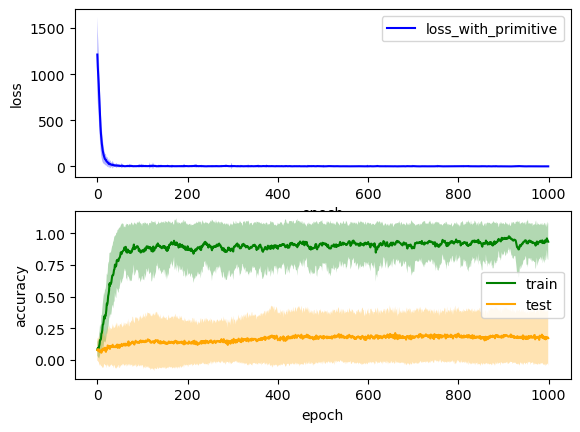

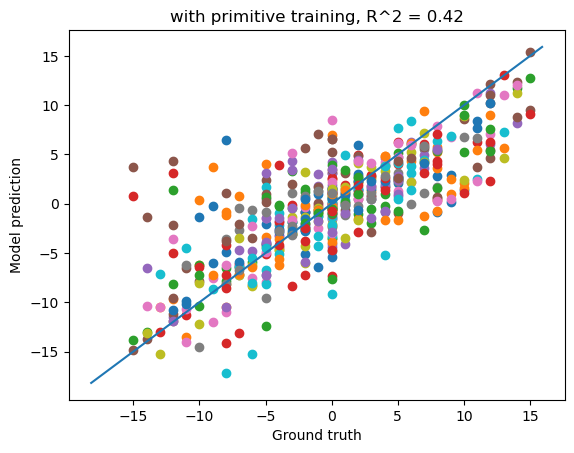

In [64]:
# standard Xavier normal, gain = 2
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 2)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  7.726137880484263
77
total time:  7.735173014799754
77 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.3 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.259740 -0.597433  0.389610
['B', '-', 'D', '='] -0.805195 -0.820132  0.389610
['C', '-', 'D', '='] -0.051948 -0.493729  0.376623
['D', '-', 'B', '=']  0.805195  0.843301  0.285714
['D', '-', 'A', '=']  0.259740  0.840128  0.233766
['D', '-', 'C', '=']  0.051948  0.201896  0.233766
['D', '-', 'D', '=']  0.000000  1.247315  0.220779

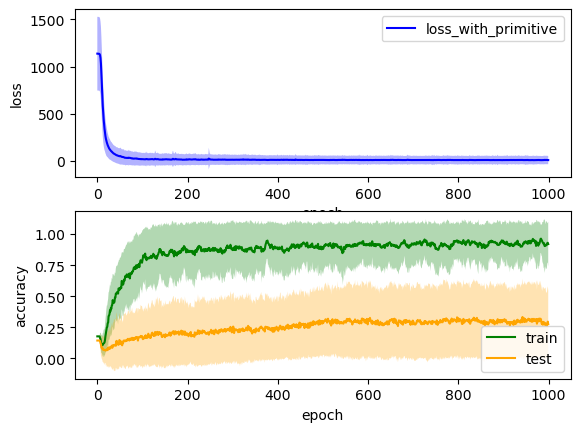

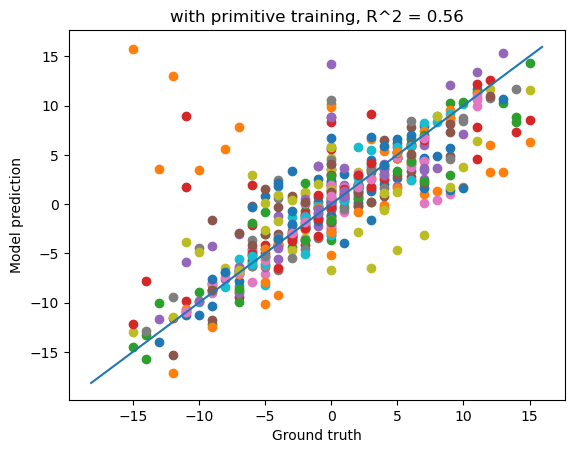

In [65]:
# standard Xavier normal, gain = 0.1
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.1)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  6.709152487913768
20
total time:  6.711446301142375
20 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.27 
-----------



label      pred   acc
trial                                      
['C', '-', 'D', '=']  -0.50 -1.618754  0.40
['A', '-', 'D', '=']  -0.05 -1.074635  0.35
['B', '-', 'D', '=']   1.60  0.573853  0.35
['D', '-', 'A', '=']   0.05  1.028978  0.30
['D', '-', 'C', '=']   0.50  0.357952  0.25
['D', '-', 'B', '=']  -1.60 -0.744590  0.15
['D', '-', 'D', '=']   0.00 -0.330796  0.10

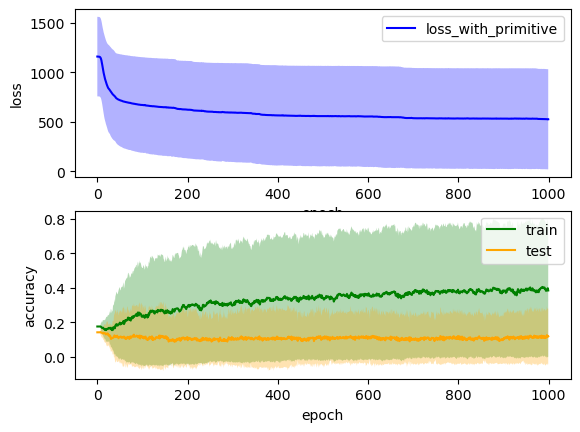

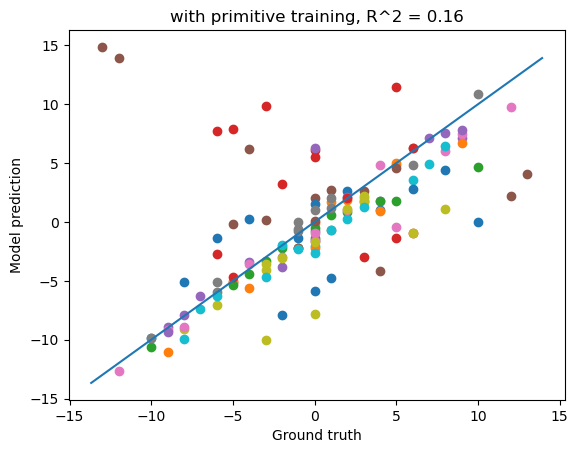

In [66]:
# standard Xavier normal, gain = 0.01
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.01)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  6.843328368663788
63
total time:  6.848892815907797
63 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.31 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.460317 -0.779025  0.460317
['B', '-', 'D', '='] -0.174603 -0.346051  0.380952
['C', '-', 'D', '='] -0.587302 -0.572357  0.380952
['D', '-', 'A', '=']  0.460317  0.228270  0.253968
['D', '-', 'C', '=']  0.587302  0.089540  0.253968
['D', '-', 'B', '=']  0.174603 -0.259366  0.222222
['D', '-', 'D', '=']  0.000000  0.010061  0.222222

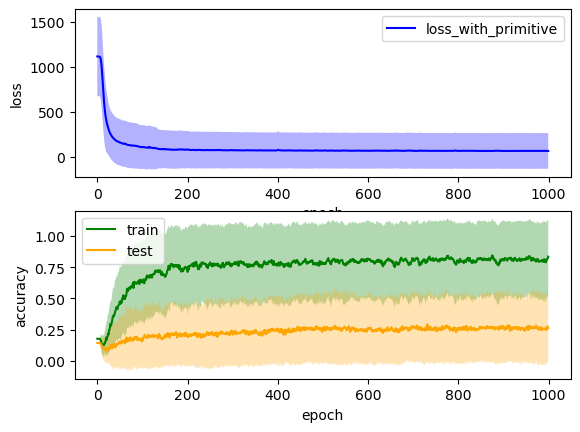

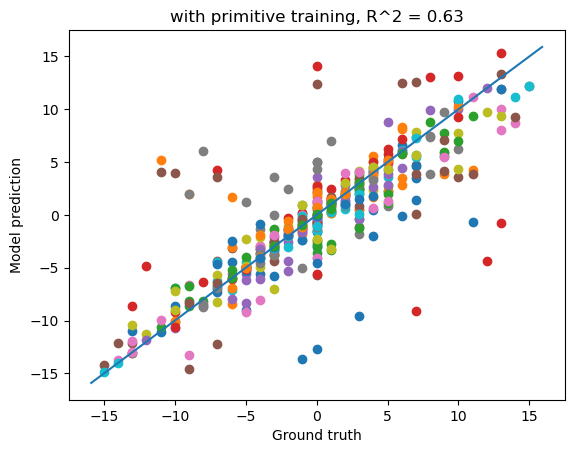

In [68]:
# standard Xavier normal, gain = 0.05
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.05)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  6.383980552355449
42
total time:  6.387604256470998
42 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['B', '-', 'D', '='] -0.119048 -0.524971  0.333333
['C', '-', 'D', '='] -0.976190 -1.178158  0.309524
['A', '-', 'D', '=']  0.357143  0.089396  0.261905
['D', '-', 'A', '='] -0.357143 -0.641316  0.261905
['D', '-', 'D', '=']  0.000000 -0.203595  0.238095
['D', '-', 'B', '=']  0.119048 -0.320319  0.142857
['D', '-', 'C', '=']  0.976190  0.651147  0.142857

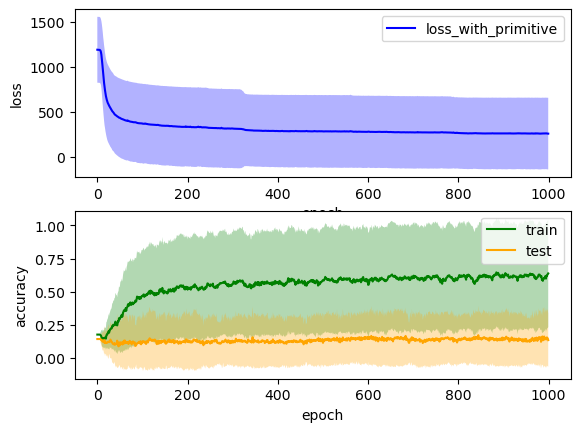

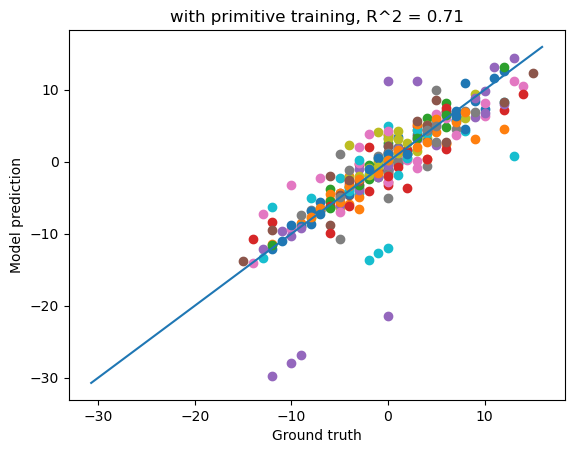

In [70]:
# standard Xavier normal, gain = 0.025
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.025)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  28.337154547373455
51
total time:  28.341609279314678
51 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.2 
-----------



label      pred       acc
trial                                             
['D', '-', 'A', '='] -0.431373  0.175676  0.235294
['D', '-', 'B', '=']  1.000000  1.190165  0.235294
['B', '-', 'D', '='] -1.000000 -0.850148  0.215686
['A', '-', 'D', '=']  0.431373  0.345782  0.196078
['C', '-', 'D', '=']  0.470588  0.455825  0.196078
['D', '-', 'D', '=']  0.000000  0.931411  0.156863
['D', '-', 'C', '='] -0.470588 -0.537769  0.137255

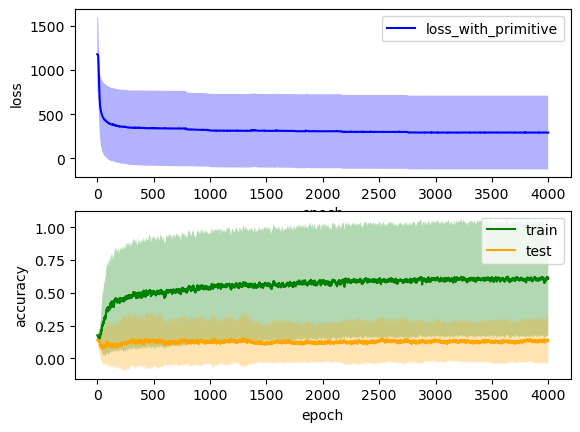

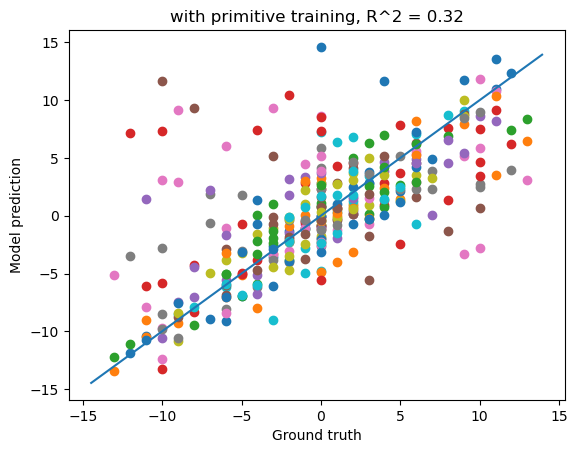

In [71]:
epochs = 4000
res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  33.3714568456014
70
total time:  33.37765039602915
70 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.27 
-----------



label      pred       acc
trial                                             
['C', '-', 'D', '='] -0.985714 -0.600163  0.357143
['A', '-', 'D', '='] -0.700000 -0.561255  0.342857
['B', '-', 'D', '=']  0.142857  0.078357  0.271429
['D', '-', 'B', '='] -0.142857 -0.688021  0.257143
['D', '-', 'C', '=']  0.985714  0.455161  0.257143
['D', '-', 'A', '=']  0.700000 -0.010559  0.214286
['D', '-', 'D', '=']  0.000000  0.876592  0.171429

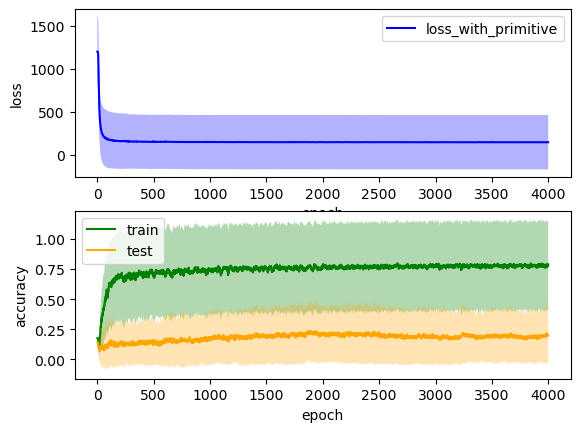

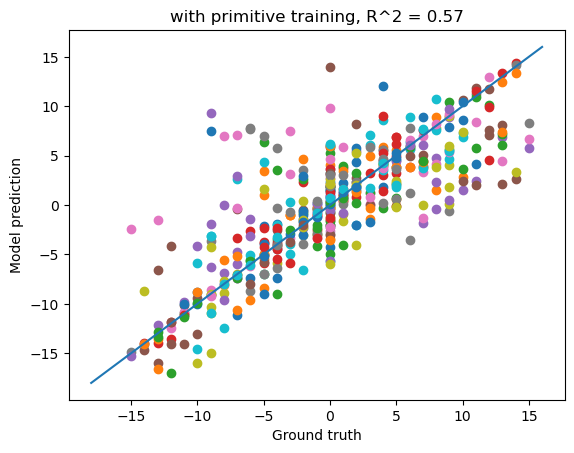

In [73]:
# standard Xavier normal, gain = 0.05
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.05)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  4.628932897249857
8
total time:  4.630108614762624
8 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.25 
-----------



label      pred    acc
trial                                       
['A', '-', 'D', '='] -1.000 -1.733636  0.375
['D', '-', 'C', '='] -1.125  0.823825  0.375
['C', '-', 'D', '=']  1.125  0.787303  0.250
['D', '-', 'B', '='] -2.375  1.406233  0.250
['D', '-', 'D', '=']  0.000  2.047840  0.250
['B', '-', 'D', '=']  2.375  2.776412  0.125
['D', '-', 'A', '=']  1.000  3.637170  0.125

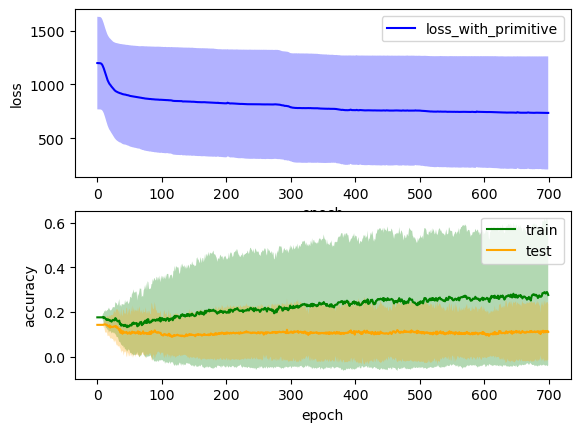

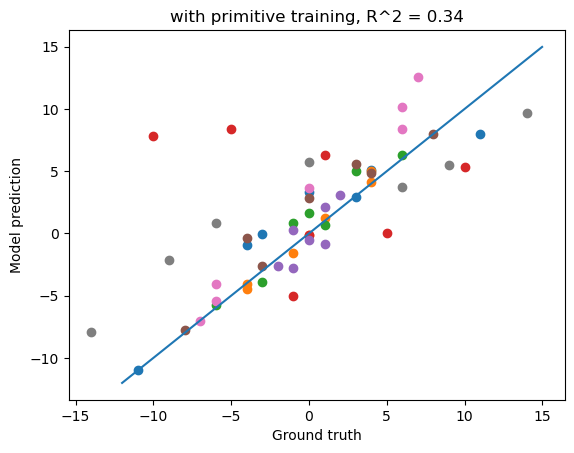

In [74]:
epochs = 700
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00005)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  5.782271985212962
13
total time:  5.784691886107127
13 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '=']  0.461538  1.301913  0.461538
['B', '-', 'D', '='] -3.538462 -3.080033  0.461538
['C', '-', 'D', '='] -1.153846 -0.162344  0.307692
['D', '-', 'B', '=']  3.538462  3.059149  0.230769
['D', '-', 'A', '='] -0.461538 -0.507680  0.076923
['D', '-', 'C', '=']  1.153846  1.116538  0.076923
['D', '-', 'D', '=']  0.000000  1.395699  0.076923

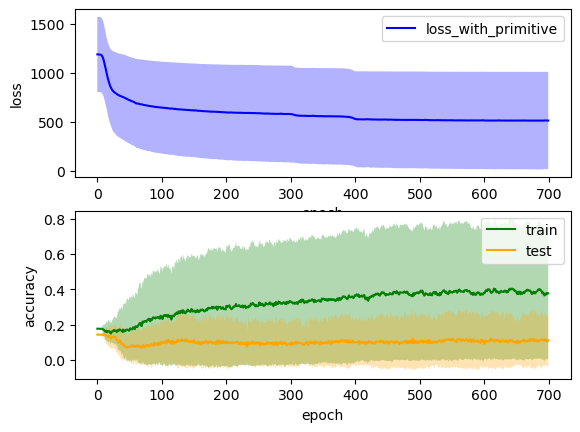

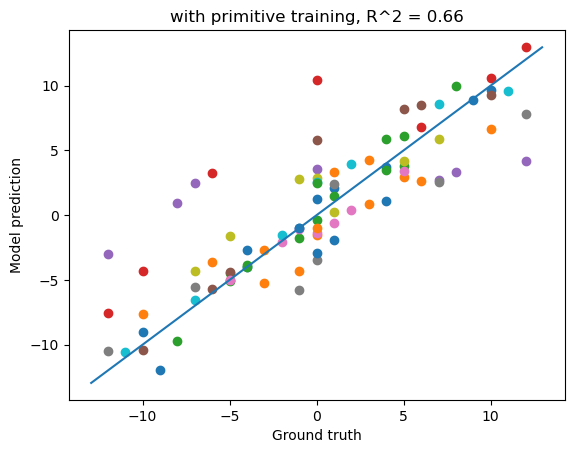

In [75]:
epochs = 1000
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.01)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  12.530553885300954
70
total time:  12.539235385258992
70 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '=']  1.657143  1.064878  0.357143
['C', '-', 'D', '=']  1.285714  0.451061  0.357143
['B', '-', 'D', '='] -0.428571 -0.885004  0.342857
['D', '-', 'D', '=']  0.000000  0.353256  0.214286
['D', '-', 'A', '='] -1.657143 -0.508775  0.142857
['D', '-', 'B', '=']  0.428571  1.138254  0.142857
['D', '-', 'C', '='] -1.285714 -0.318019  0.142857

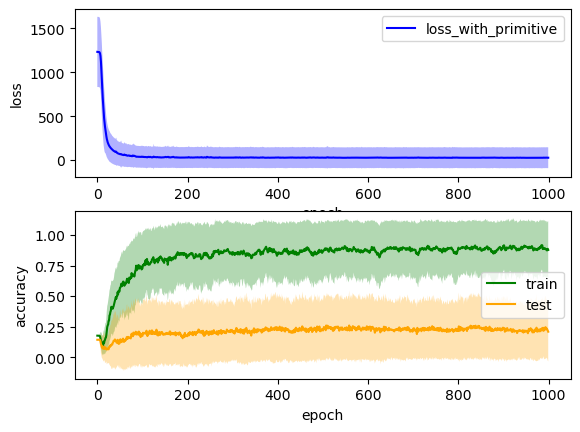

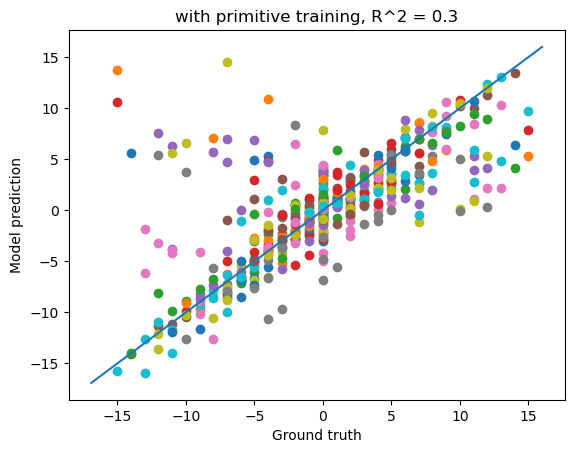

In [76]:
epochs = 1000
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.1)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  6.558053302764892
19
total time:  6.560663402080536
19 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.28 
-----------



label      pred       acc
trial                                             
['C', '-', 'D', '=']  0.473684  1.181902  0.421053
['A', '-', 'D', '='] -1.684211 -1.067949  0.315789
['B', '-', 'D', '='] -1.684211 -0.973254  0.315789
['D', '-', 'B', '=']  1.684211 -2.556019  0.315789
['D', '-', 'C', '='] -0.473684 -5.275843  0.210526
['D', '-', 'D', '=']  0.000000 -3.051729  0.210526
['D', '-', 'A', '=']  1.684211 -2.715842  0.157895

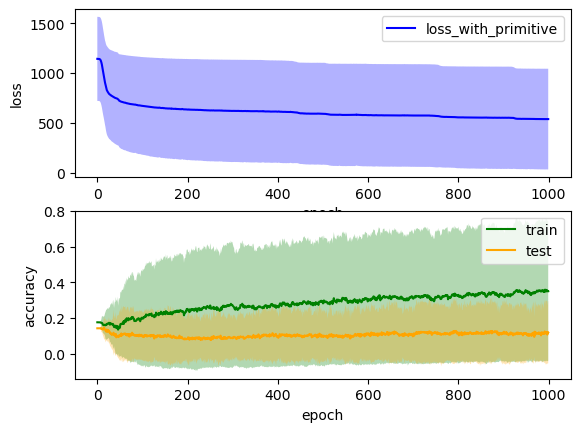

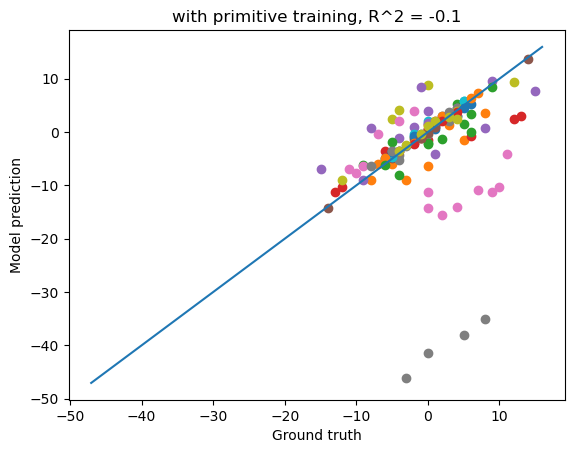

In [77]:
# standard Xavier normal, gain = 0.001
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.008)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']

run time:  12.7634845495224
70
total time:  12.771027549107869
70 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.27 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '='] -0.785714 -1.398703  0.414286
['B', '-', 'D', '='] -0.514286 -0.817809  0.342857
['C', '-', 'D', '='] -0.200000 -0.624443  0.342857
['D', '-', 'C', '=']  0.200000 -0.829079  0.228571
['D', '-', 'A', '=']  0.785714  0.045269  0.214286
['D', '-', 'B', '=']  0.514286 -0.174590  0.185714
['D', '-', 'D', '=']  0.000000 -0.523458  0.171429

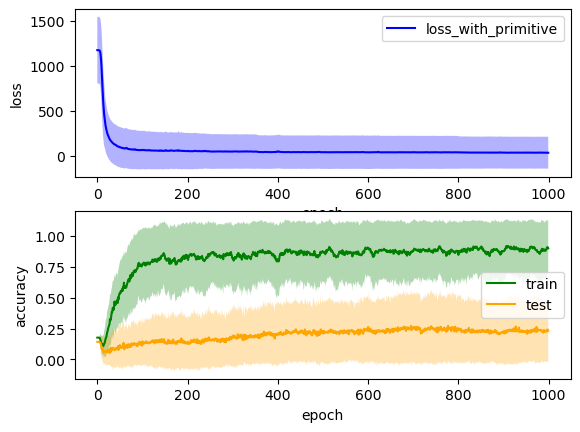

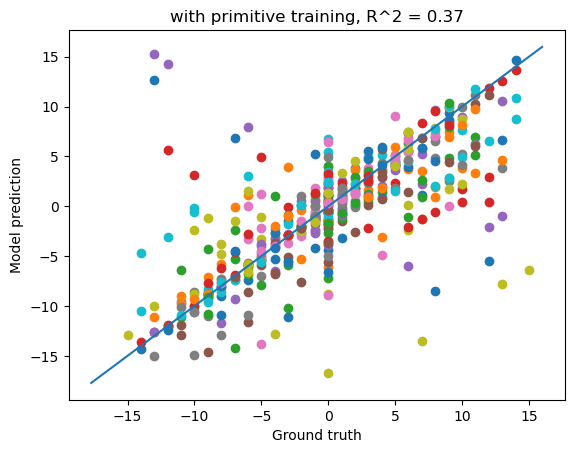

In [78]:
# standard Xavier normal, gain = 0.001
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.08)

res1 = run_plot(trainseqs_n, testseqs_n, cue_dict)
res1['df_trials']